In [ ]:
'''

This notebook is stil work in progress

'''

In [59]:
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import sys
import logging
import os
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
import pickle
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Helper functions  - Evaluating the model

def save_confusion_matrix(y_true, y_pred, output_dir, file_name):
    """
    Stores the confusion matrix in the file path
    """
    labels = [
        'None', 'KpEverTgthr', 'GetStudRelate', 'Restat',
        'Revoic', 'PrsAcc', 'PrsRsn'
    ]
    conf_matrix = confusion_matrix(y_true, y_pred)
    svm = sns.heatmap(
        conf_matrix/conf_matrix.sum(axis=1)[:, None],
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        annot=True,
    )
    figure = svm.get_figure()
    figure.savefig(output_dir + "/" + file_name + ".png", dpi=600)
    figure.clear()


def custom_micro_f1_score(true_labels, pred_labels, label_count=7):
    """
    This computes a custom micro f1 score ignoring
    the predictions associated with label None (0)

    This code still has to undergo some testing
    """

    none_label = 0

    ref_count = sum([1 for true in true_labels if true != none_label])
    pred_count = sum([1 for pred in pred_labels if pred != none_label])
    match_count = sum([1 for true, pred in zip(true_labels, pred_labels)
                       if true == pred and true != none_label])

    micro_precision = match_count / pred_count if pred_count != 0 else 0
    micro_recall = match_count / ref_count if ref_count != 0 else 0
    micro_f1 = 2/(1/micro_precision + 1/micro_recall) \
        if micro_precision != 0 and micro_recall != 0 else 0

    return(micro_precision, micro_recall, micro_f1)


def custom_macro_f1_score(true_labels, pred_labels, label_count=7):
    """
    This computes a custom macro f1 score ignoring
    in its entirety, the predictions associated
    with the label None (0)


    This code still has to undergo some testing
    """

    none_label = 0

    stats = defaultdict(Counter)

    for true_label, pred_label in zip(true_labels, pred_labels):

        stats[true_label]['tp+fn'] += 1

        if true_label == pred_label:
            stats[true_label]['tp'] += 1

        stats[pred_label]['tp+fp'] += 1

    for label in set(pred_labels):
        if stats[label]['tp+fp'] != 0:
            stats[label]['precision'] = \
                stats[label]['tp']/stats[label]['tp+fp']
        if stats[label]['tp+fn'] != 0:
            stats[label]['recall'] = stats[label]['tp']/stats[label]['tp+fn']
        if stats[label]['precision'] != 0 and stats[label]['recall'] != 0:
            stats[label]['f1'] = \
                2.0/(1/stats[label]['precision'] + 1/stats[label]['recall'])

    macro_precision = sum(
        [stats[lbl]['precision'] for lbl in stats.keys() if lbl != none_label]
    )/(label_count - 1)

    macro_recall = sum(
        [stats[lbl]['recall'] for lbl in stats.keys() if lbl != none_label]
    )/(label_count - 1)

    macro_f1 = 2/(1/macro_precision + 1/macro_recall) \
        if macro_precision != 0 and macro_recall != 0 else 0

    return macro_f1, stats


class TalkBackDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data,
        tokenizer,
        max_seq_length
    ):

        input_examples = [
            (
                '' if datum[1].text_a is np.nan else datum[1].text_a.lower(),
                '' if datum[1].text_b is np.nan else datum[1].text_b.lower()
            ) for datum in data.iterrows()
        ]
        self.examples = tokenizer.batch_encode_plus(
            batch_text_or_text_pairs=input_examples,
            max_length=max_seq_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        self.labels = [
            torch.tensor(int(label), dtype=torch.long) for label in data.labels
        ]
        
        self.damsl_labels = [
            str(label) for label in data.damsl_labels
        ]

    def __len__(self):
        return len(self.examples['input_ids'])

    def __getitem__(self, index):
        """
            Use one if the other fails
        """
        answer = {}
        for key in self.examples:
            answer[key] = self.examples[key][index]

        answer['label'] = self.labels[index]
        answer['damsl_label'] = self.damsl_labels[index]
        return answer

In [3]:
torch.cuda.empty_cache() 
import gc
gc.collect()
from keras import backend as K
K.clear_session()

import wandb
wandb.login()

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda

True

In [4]:
def fetch_train_valid_testsets(tokenizer, max_seq_length=128, seed=1010):
    '''
    Arguments:
        tokenizer - BERT tokenizer
        max_seq_length - Maximum sequence length
        seed - Random seed

    Returns:
        train_df - Training set (Pandas dataframe)
        valid_df - Validation set (Pandas dataframe)
        test_df - Testing set (Pandas dataframe)
    '''
    '''
    the data in TSV format.
    Contains three colums:
        text_a (previous student sentence);
        text_b (teacher sentence);
        labels (category or TalkMove label)
    '''
    train_data = pd.read_csv(
        '../data/train_teacher_dact.tsv', sep='\t'
    )
    
    valid_data = pd.read_csv(
        '../data/test_teacher_dact.tsv', sep='\t'
    )
    
    test_data = pd.read_csv(
        '../data/test_teacher_dact.tsv', sep='\t'
    )


    X_train, X_test, y_train, y_test =  train_data, test_data, train_data.labels, test_data.labels
    X_valid, y_valid = valid_data, valid_data.labels
    
    train_df = X_train.replace(np.nan, '', regex=True)
    train_df = TalkBackDataset(train_df, tokenizer, max_seq_length)
    
    valid_df = X_valid.replace(np.nan, '', regex=True)
    valid_df = TalkBackDataset(valid_df, tokenizer, max_seq_length)
    
    test_df = X_test.replace(np.nan, '', regex=True)
    test_df = TalkBackDataset(test_df, tokenizer, max_seq_length)

    return(train_df, valid_df, test_df)


def compute_metrics(pred):
    '''
    Arguments:
        pred - predictions

    Returns:
        accuracy, Micro F1, Macro F1 and MCC scoresoutput_attentions=True,  

    '''
    true_labels = pred.label_ids
    #print(type(pred), pred.predictions.shape, pred.predictions)
    pred_labels = pred.predictions.argmax(-1)
    _, _, mif1 = custom_micro_f1_score(true_labels, pred_labels)
    maf1, _ = custom_macro_f1_score(true_labels, pred_labels)
    acc = accuracy_score(true_labels, pred_labels)
    matthew_corr = matthews_corrcoef(true_labels, pred_labels)

    return {
        'accuracy': acc,
        'micro_f1': mif1,
        'macro_f1': maf1,
        'matthew_corr_coeff': matthew_corr
    }


def test_compute_metrics(pred, model_store):
    _, _, mif1 = custom_micro_f1_score(true_labels, pred_labels)
    maf1, _ = custom_macro_f1_score(true_labels, pred_labels)

    print(confusion_matrix(true_labels, pred_labels))
    #print(save_confusion_matrix(true_labels, pred_labels, model_store, "unseen"))
    print(classification_report(true_labels, pred_labels))
    print(matthews_corrcoef(true_labels, pred_labels))
    return mif1, maf1

In [5]:
#Command line agrument - Folder name where the model outputs can be stored
folder_name = '../../../baseline_public/'

#Command line argument  - Random seed
seed = 1022
model_store = folder_name + "/model_storage/"

#if the model storage folder does not exist, create it
if not os.path.exists(model_store):
    os.makedirs(model_store)

#Log the process to help with debugging. All the logs will be saved in the corresponding folder
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers-" + str(seed))
transformers_logger.setLevel(logging.INFO)

In [ ]:
'''
Arguments for model training Including:
    output_dir - Store the outputs of the checkpoints as well as the best model
    learning_rate - learning learning_rate
    num_train_epochs - Number of training epochs (Tuning)
    per_device_train_batch_size - Training batch size
    per_device_eval_batch_size - validation batch size
    warmup_steps - Number of warmup steps
        Warmup steps are just a few updates with low learning rate before / at the beginning of training.
        After this warmup, you use the regular learning rate (schedule) to train your model to convergence.
        The idea that this helps your network to slowly adapt to the data intuitively makes sense.
        However, theoretically, the main reason for warmup steps is to allow adaptive optimisers (e.g. Adam, RMSProp, ...)
        to compute correct statistics of the gradients. Therefore, a warmup period makes little sense when training with plain SGD.
    overwrite_output_dir - Overwrite the output directory
    fp16 - 16 point precision - Speed up the process
    save_steps - save checkpoints to the model output folder
    evaluation_strategy - Evaluation is done at the end of each epoch.
    logging_dir - Folder to save the logs
'''
training_args = TrainingArguments(
    output_dir=model_store,
    learning_rate=2e-5,
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=1000,
    overwrite_output_dir=True,
    fp16=False,
    seed=seed,
    save_steps=30000,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    eval_accumulation_steps=1
)


#Pretrained model to download and use including the number of labels
model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base', num_labels=7, output_hidden_states=True
)

#Select the tokenizer to use
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
#Fetch the data
train_df, valid_df, test_df = fetch_train_valid_testsets(tokenizer)
print(len(train_df), len(valid_df), len(test_df))

#Set up the DNN model trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train_df,
    eval_dataset = valid_df,
    compute_metrics=None
)

In [ ]:
#Train and evaluate the model
trainer.train()
trainer.evaluate()

In [ ]:
model.save_pretrained('../../baseline_public/'+'teacher_dact_roberta_base.pth')

In [8]:
val_split = np.array_split(test_df, 20)
pred_labels = []
true_labels = []
for item in val_split:
    val = trainer.predict(test_dataset=item)
    true_labels.extend([id for id in val.label_ids])
    pred_labels.extend([id for id in val.predictions[0].argmax(-1)])
mif1, maf1 = test_compute_metrics(pred_labels, true_labels)
print(mif1, maf1)

/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[[12457   429    30   101    96   290    23]
 [  587  1649    33    17     7   110     7]
 [   31    13   142     0     0    29     3]
 [  131    21     1    96     2     5     0]
 [  304    23     0    22    90     9     0]
 [  240    84    13    27     5  2183    32]
 [    8     1     1     0     0    25   183]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     13426
           1       0.74      0.68      0.71      2410
           2       0.65      0.65      0.65       218
           3       0.37      0.38      0.37       256
           4       0.45      0.20      0.28       448
           5       0.82      0.84      0.83      2584
           6       0.74      0.84      0.79       218

   micro avg       0.86      0.86      0.86     19560
   macro avg       0.67      0.65      0.65     19560
weighted avg       0.85      0.86      0.85     19560

0.70943406230943
0.7277144772117963 0.6130436086110573


# Load Saved Model and prepare dataset

In [6]:
import torch.nn as nn
model = AutoModelForSequenceClassification.from_pretrained('../../baseline_public/'+'teacher_dact_roberta_base.pth/', local_files_only=True)
model= nn.DataParallel(model)
model.to('cuda')

DataParallel(
  (module): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(i

In [7]:
training_args = TrainingArguments(
    output_dir=model_store,
    learning_rate=3e-5,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    overwrite_output_dir=True,
    fp16=False,
    seed=seed,
    save_steps=30000,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    eval_accumulation_steps=1
)


#Select the tokenizer to use
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

#Fetch the data
train_df, valid_df, test_df = fetch_train_valid_testsets(tokenizer)
val_split = np.array_split(test_df, 3)

#Set up the DNN model trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=valid_df,
    compute_metrics=None
)

/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda3/env

In [9]:
train_data = pd.read_csv(
    '../data/train_teacher_dact.tsv', sep='\t'
)
target = list(set(train_data['damsl_labels']))

def one_hot(array):
    unique, inverse = np.unique(array, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot

one_hot_vectors = one_hot(target)
one_hot_target = {}
for i in range(len(target)):
    one_hot_target[target[i]] = one_hot_vectors[i]
    
print(one_hot_target)

{'sd': array([0., 0., 0., 0., 0., 1., 0.]), 'qy': array([0., 0., 0., 0., 1., 0., 0.]), 'ba': array([0., 0., 1., 0., 0., 0., 0.]), 'b': array([0., 1., 0., 0., 0., 0., 0.]), 'sv': array([0., 0., 0., 0., 0., 0., 1.]), 'fc': array([0., 0., 0., 1., 0., 0., 0.]), 'aa': array([1., 0., 0., 0., 0., 0., 0.])}


In [11]:
'''
Getting the embeddings of size - 768
Get the one-hot encoding vector - 7

'''
train_x = np.array([])
train_y = np.array([])

df_split = np.array_split(train_df, 30)
i = 1
for item in df_split:
    temp = trainer.predict(test_dataset=item)
    embeddings = np.array([i[0] for i in temp.predictions[1][12]])
    one_hot_damsl = [one_hot_target[i['damsl_label']] for i in item]
    combined = np.array([np.concatenate((embeddings[i], one_hot_damsl[i]), axis=0) for i in range(len(embeddings))])
    target_labels = np.array([i['label'].cpu().detach().numpy() for i in item])
    if  i == 1: 
        train_x = combined
        train_y = target_labels
    else:
        train_x = np.append(train_x, combined, axis=0)
        train_y = np.append(train_y, target_labels, axis=0)
    i+=1

print(train_x.shape, train_y.shape)
    
with open('../../train_dact_embeddings.pkl', 'wb') as f:
    pickle.dump([train_x, train_y], f, protocol=pickle.HIGHEST_PROTOCOL)

(143829, 775) (143829,)


In [12]:
'''
Getting the embeddings of size - 768
Get the one-hot encoding vector - 7

'''
test_x = np.array([])
test_y = np.array([])

df_split = np.array_split(test_df, 10)
i = 1
for item in df_split:
    temp = trainer.predict(test_dataset=item)
    embeddings = np.array([i[0] for i in temp.predictions[1][12]])
    one_hot_damsl = [one_hot_target[i['damsl_label']] for i in item]
    target_labels = np.array([i['label'].cpu().detach().numpy() for i in item])
    combined = np.array([np.concatenate((embeddings[i], one_hot_damsl[i]), axis=0) for i in range(len(embeddings))])
    if  i == 1: 
        test_x = combined
        test_y = target_labels
    else:
        test_x = np.append(test_x, combined, axis=0)
        test_y = np.append(test_y, target_labels, axis=0)
    i += 1

print(test_x.shape, test_y.shape)
    
with open('../../test_dact_embeddings.pkl', 'wb') as f:
    pickle.dump([test_x, test_y], f, protocol=pickle.HIGHEST_PROTOCOL)

(19560, 775) (19560,)


# Train and Test model to predict Talk moves based on concatenated embeddings

In [71]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 19560

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [72]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([19560, 775])
Sample input: 
 tensor([[-0.3037, -1.1001,  0.6740,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2577, -1.5493,  1.0307,  ...,  0.0000,  1.0000,  0.0000],
        [-0.4984, -1.3651,  0.4327,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [-0.1132, -1.3215,  0.5682,  ...,  0.0000,  1.0000,  0.0000],
        [-0.9925, -1.8903,  0.5632,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.7415,  0.1074, -0.0606,  ...,  0.0000,  1.0000,  0.0000]],
       dtype=torch.float64)
Sample input: 
 tensor([0, 0, 0,  ..., 0, 0, 5])


In [117]:
# Train the new model
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 7)
    
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = F.log_softmax(output, dim=1)
        return output


In [118]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [119]:
model = Feedforward(775, 1620)

#moving to gpu
model.to(device)

print(model)

Feedforward(
  (fc1): Linear(in_features=775, out_features=1620, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1620, out_features=7, bias=True)
)


In [120]:
# loss and optimization functions
lr=0.0001

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [121]:
# function to predict accuracy
def mcc(pred, target):
    pred_y = torch.round(pred.argmax(-1).float().squeeze()).cpu().detach().numpy()
    target_y = np.array([float(i) for i in target.cpu().detach().numpy()])
    
    _, _, mif1 = custom_micro_f1_score(target_y, pred_y)
    maf1, _ = custom_macro_f1_score(target_y, pred_y)

    #print(confusion_matrix(target_y, pred_y))
    #print(classification_report(target_y, pred_y))
    #print(matthews_corrcoef(target_y, pred_y))
    #print(maf1, mif1)
    return torch.tensor(maf1)

In [123]:
epochs = 1000
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)   

        model.zero_grad()
        output = model(inputs.float())
        #print(output.shape, labels.shape)
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()
        train_losses.append(loss.item())
        # calculating mcc
        accuracy = mcc(output,labels)
        train_acc += accuracy
        
        optimizer.step()
 
    
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs.float())
            val_loss = criterion(output.squeeze(), labels.long())

            val_losses.append(val_loss.item())
            
            accuracy = mcc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_score : {epoch_train_acc} val_score : {epoch_val_acc}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../../../state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 1.1059598699212074 val_loss : 0.5925055742263794
train_score : 2.394859075138811e-05 val_score : 2.1926585759501904e-05
Validation loss decreased (inf --> 0.592506).  Saving model ...
Epoch 2
train_loss : 0.36460597813129425 val_loss : 0.4961670935153961
train_score : 3.089259917032905e-05 val_score : 2.355009928578511e-05
Validation loss decreased (0.592506 --> 0.496167).  Saving model ...
Epoch 3
train_loss : 0.2758903093636036 val_loss : 0.5093463659286499
train_score : 3.48027897416614e-05 val_score : 2.6570543923298828e-05
Epoch 4
train_loss : 0.25008177757263184 val_loss : 0.5061612725257874
train_score : 3.923468466382474e-05 val_score : 2.944473089883104e-05
Epoch 5
train_loss : 0.23024428077042103 val_loss : 0.4956793189048767
train_score : 4.231636194163002e-05 val_score : 3.070936872973107e-05
Validation loss decreased (0.496167 --> 0.495679).  Saving model ...
Epoch 6
train_loss : 0.2199031561613083 val_loss : 0.48795413970947266
train_score : 4.3844378

Epoch 40
train_loss : 0.20270264893770218 val_loss : 0.4627295136451721
train_score : 4.417216405272484e-05 val_score : 3.108157397946343e-05
Epoch 41
train_loss : 0.20267910324037075 val_loss : 0.4623699486255646
train_score : 4.420725235831924e-05 val_score : 3.114562787231989e-05
Epoch 42
train_loss : 0.20186679065227509 val_loss : 0.4622545540332794
train_score : 4.417895252117887e-05 val_score : 3.1135266908677295e-05
Epoch 43
train_loss : 0.20216416008770466 val_loss : 0.462779700756073
train_score : 4.4175219954922795e-05 val_score : 3.1076699087861925e-05
Epoch 44
train_loss : 0.20117821916937828 val_loss : 0.4630518853664398
train_score : 4.4192645873408765e-05 val_score : 3.1077899620868266e-05
Epoch 45
train_loss : 0.20196669176220894 val_loss : 0.46310654282569885
train_score : 4.4241056457394734e-05 val_score : 3.111006662948057e-05
Epoch 46
train_loss : 0.2009449154138565 val_loss : 0.46260765194892883
train_score : 4.422717393026687e-05 val_score : 3.112496779067442e-05


Epoch 83
train_loss : 0.19711185805499554 val_loss : 0.46785271167755127
train_score : 4.45273908553645e-05 val_score : 3.098283559666015e-05
Epoch 84
train_loss : 0.1966867782175541 val_loss : 0.4668912887573242
train_score : 4.430282206158154e-05 val_score : 3.106538497377187e-05
Epoch 85
train_loss : 0.19751008041203022 val_loss : 0.4669138491153717
train_score : 4.445459126145579e-05 val_score : 3.101911715930328e-05
Epoch 86
train_loss : 0.19705996476113796 val_loss : 0.46718424558639526
train_score : 4.4359541789162904e-05 val_score : 3.109173121629283e-05
Epoch 87
train_loss : 0.19697227142751217 val_loss : 0.4675455093383789
train_score : 4.427112435223535e-05 val_score : 3.11184958263766e-05
Epoch 88
train_loss : 0.19623480923473835 val_loss : 0.4675220549106598
train_score : 4.4397242163540795e-05 val_score : 3.110440957243554e-05
Epoch 89
train_loss : 0.19556289166212082 val_loss : 0.468397319316864
train_score : 4.432447531144135e-05 val_score : 3.107082739006728e-05
Epoch 

Epoch 126
train_loss : 0.1920426432043314 val_loss : 0.4730525314807892
train_score : 4.4555006752489135e-05 val_score : 3.111458136118017e-05
Epoch 127
train_loss : 0.19393381103873253 val_loss : 0.47274911403656006
train_score : 4.439914846443571e-05 val_score : 3.1089221010915935e-05
Epoch 128
train_loss : 0.19303688034415245 val_loss : 0.4728095829486847
train_score : 4.4595799408853054e-05 val_score : 3.097558146691881e-05
Epoch 129
train_loss : 0.19196996092796326 val_loss : 0.4721404016017914
train_score : 4.464348603505641e-05 val_score : 3.106862277491018e-05
Epoch 130
train_loss : 0.19245866499841213 val_loss : 0.4742448031902313
train_score : 4.456733222468756e-05 val_score : 3.100502726738341e-05
Epoch 131
train_loss : 0.1914099119603634 val_loss : 0.47274765372276306
train_score : 4.4690430513583124e-05 val_score : 3.103832568740472e-05
Epoch 132
train_loss : 0.19231132976710796 val_loss : 0.47444602847099304
train_score : 4.4527223508339375e-05 val_score : 3.0990540835773

Epoch 169
train_loss : 0.18648160621523857 val_loss : 0.4784817695617676
train_score : 4.4817832531407475e-05 val_score : 3.1077048333827406e-05
Epoch 170
train_loss : 0.18793990835547447 val_loss : 0.4792412519454956
train_score : 4.4721651647705585e-05 val_score : 3.103348353761248e-05
Epoch 171
train_loss : 0.18737865798175335 val_loss : 0.4788021147251129
train_score : 4.4779168092645705e-05 val_score : 3.094262501690537e-05
Epoch 172
train_loss : 0.1869767438620329 val_loss : 0.4792070686817169
train_score : 4.4839900510851294e-05 val_score : 3.090429163421504e-05
Epoch 173
train_loss : 0.18728677928447723 val_loss : 0.480108380317688
train_score : 4.477657421375625e-05 val_score : 3.0850813345750794e-05
Epoch 174
train_loss : 0.18722187168896198 val_loss : 0.47892147302627563
train_score : 4.477184120332822e-05 val_score : 3.1059487810125574e-05
Epoch 175
train_loss : 0.18725388683378696 val_loss : 0.47764351963996887
train_score : 4.474464731174521e-05 val_score : 3.112575723207

Epoch 212
train_loss : 0.18214849941432476 val_loss : 0.485166996717453
train_score : 4.502430238062516e-05 val_score : 3.089631354669109e-05
Epoch 213
train_loss : 0.18205120041966438 val_loss : 0.4870918393135071
train_score : 4.502575029619038e-05 val_score : 3.092112820013426e-05
Epoch 214
train_loss : 0.18152406439185143 val_loss : 0.4840904176235199
train_score : 4.507183621171862e-05 val_score : 3.08746712107677e-05
Epoch 215
train_loss : 0.18275990895926952 val_loss : 0.48704996705055237
train_score : 4.491646177484654e-05 val_score : 3.098836896242574e-05
Epoch 216
train_loss : 0.18076981231570244 val_loss : 0.4862353205680847
train_score : 4.510317376116291e-05 val_score : 3.0908689950592816e-05
Epoch 217
train_loss : 0.1820842456072569 val_loss : 0.4851098656654358
train_score : 4.5103726733941585e-05 val_score : 3.092552287853323e-05
Epoch 218
train_loss : 0.18055866099894047 val_loss : 0.4876234829425812
train_score : 4.502373849391006e-05 val_score : 3.090263999183662e-05

Epoch 255
train_loss : 0.1768688950687647 val_loss : 0.49205198884010315
train_score : 4.535511470749043e-05 val_score : 3.0878167308401316e-05
Epoch 256
train_loss : 0.17639952339231968 val_loss : 0.49525678157806396
train_score : 4.5345899707172066e-05 val_score : 3.09482857119292e-05
Epoch 257
train_loss : 0.17649554088711739 val_loss : 0.49325960874557495
train_score : 4.5368855353444815e-05 val_score : 3.0807605071458966e-05
Epoch 258
train_loss : 0.1766907051205635 val_loss : 0.49380508065223694
train_score : 4.534814434009604e-05 val_score : 3.090887184953317e-05
Epoch 259
train_loss : 0.17550713941454887 val_loss : 0.49325302243232727
train_score : 4.539580913842656e-05 val_score : 3.090819882345386e-05
Epoch 260
train_loss : 0.17600986547768116 val_loss : 0.4933716952800751
train_score : 4.532675302471034e-05 val_score : 3.0660849006380886e-05
Epoch 261
train_loss : 0.1753797996789217 val_loss : 0.493501752614975
train_score : 4.538522262009792e-05 val_score : 3.08514208882115

Epoch 298
train_loss : 0.1704870406538248 val_loss : 0.4997986853122711
train_score : 4.572686884785071e-05 val_score : 3.07905902445782e-05
Epoch 299
train_loss : 0.1704283133149147 val_loss : 0.5005829334259033
train_score : 4.5643853809451684e-05 val_score : 3.075127096963115e-05
Epoch 300
train_loss : 0.17045506089925766 val_loss : 0.5045170783996582
train_score : 4.5630244130734354e-05 val_score : 3.084785203100182e-05
Epoch 301
train_loss : 0.16992969810962677 val_loss : 0.4998342990875244
train_score : 4.5646229409612715e-05 val_score : 3.0724397220183164e-05
Epoch 302
train_loss : 0.16915517300367355 val_loss : 0.500457227230072
train_score : 4.5732966100331396e-05 val_score : 3.079335147049278e-05
Epoch 303
train_loss : 0.16929837688803673 val_loss : 0.49696481227874756
train_score : 4.57938585896045e-05 val_score : 3.0652157875010744e-05
Epoch 304
train_loss : 0.1699720174074173 val_loss : 0.50449538230896
train_score : 4.576688661472872e-05 val_score : 3.076574284932576e-05


Epoch 341
train_loss : 0.16420220397412777 val_loss : 0.5063361525535583
train_score : 4.6018973080208525e-05 val_score : 3.086708966293372e-05
Epoch 342
train_loss : 0.16384436562657356 val_loss : 0.5118513107299805
train_score : 4.611213807947934e-05 val_score : 3.072797699132934e-05
Epoch 343
train_loss : 0.16360093280673027 val_loss : 0.5069221258163452
train_score : 4.6092300181044266e-05 val_score : 3.067177385673858e-05
Epoch 344
train_loss : 0.16286278516054153 val_loss : 0.5133616328239441
train_score : 4.602785702445544e-05 val_score : 3.079478119616397e-05
Epoch 345
train_loss : 0.1636542435735464 val_loss : 0.5051266551017761
train_score : 4.6031505917198956e-05 val_score : 3.070078309974633e-05
Epoch 346
train_loss : 0.1632143296301365 val_loss : 0.5092378258705139
train_score : 4.60994488094002e-05 val_score : 3.075880158576183e-05
Epoch 347
train_loss : 0.16374505870044231 val_loss : 0.5121081471443176
train_score : 4.597636507241987e-05 val_score : 3.068212026846595e-05

Epoch 384
train_loss : 0.15732809901237488 val_loss : 0.5167813897132874
train_score : 4.63125434180256e-05 val_score : 3.066494537051767e-05
Epoch 385
train_loss : 0.15672233700752258 val_loss : 0.5206883549690247
train_score : 4.644305590773001e-05 val_score : 3.075762651860714e-05
Epoch 386
train_loss : 0.15699257142841816 val_loss : 0.5168892741203308
train_score : 4.643607826437801e-05 val_score : 3.070096863666549e-05
Epoch 387
train_loss : 0.15661074593663216 val_loss : 0.5220664739608765
train_score : 4.639293547370471e-05 val_score : 3.069641024922021e-05
Epoch 388
train_loss : 0.15611256286501884 val_loss : 0.519896924495697
train_score : 4.657823228626512e-05 val_score : 3.067014768021181e-05
Epoch 389
train_loss : 0.15694663301110268 val_loss : 0.5199648141860962
train_score : 4.629749309970066e-05 val_score : 3.0703329684911296e-05
Epoch 390
train_loss : 0.15637456811964512 val_loss : 0.52085942029953
train_score : 4.6362121793208644e-05 val_score : 3.0786952265771106e-05


Epoch 427
train_loss : 0.15123739279806614 val_loss : 0.5244140625
train_score : 4.682667349698022e-05 val_score : 3.053452383028343e-05
Epoch 428
train_loss : 0.15008282102644444 val_loss : 0.5320975184440613
train_score : 4.67919853690546e-05 val_score : 3.0734165193280205e-05
Epoch 429
train_loss : 0.15026183612644672 val_loss : 0.5240243077278137
train_score : 4.687572436523624e-05 val_score : 3.062932955799624e-05
Epoch 430
train_loss : 0.15034768730401993 val_loss : 0.5218722820281982
train_score : 4.686991815106012e-05 val_score : 3.056970308534801e-05
Epoch 431
train_loss : 0.1504769939929247 val_loss : 0.5223926901817322
train_score : 4.677316246670671e-05 val_score : 3.067110083065927e-05
Epoch 432
train_loss : 0.15016229264438152 val_loss : 0.5289232730865479
train_score : 4.6835659304633737e-05 val_score : 3.073483821935952e-05
Epoch 433
train_loss : 0.15028774365782738 val_loss : 0.5219335556030273
train_score : 4.6744109567953274e-05 val_score : 3.0614268325734884e-05
Epo

Epoch 470
train_loss : 0.14453392289578915 val_loss : 0.5320388674736023
train_score : 4.715822069556452e-05 val_score : 3.0674185836687684e-05
Epoch 471
train_loss : 0.1435686144977808 val_loss : 0.5362977981567383
train_score : 4.7240915591828525e-05 val_score : 3.063444091822021e-05
Epoch 472
train_loss : 0.14325899071991444 val_loss : 0.5327261686325073
train_score : 4.713693851954304e-05 val_score : 3.054531043744646e-05
Epoch 473
train_loss : 0.1434956006705761 val_loss : 0.5333012342453003
train_score : 4.7237361286533996e-05 val_score : 3.0677299946546555e-05
Epoch 474
train_loss : 0.14337296783924103 val_loss : 0.534065306186676
train_score : 4.719323624158278e-05 val_score : 3.0654144211439416e-05
Epoch 475
train_loss : 0.14328479953110218 val_loss : 0.5321880578994751
train_score : 4.736768823931925e-05 val_score : 3.067531724809669e-05
Epoch 476
train_loss : 0.14398550800979137 val_loss : 0.539006233215332
train_score : 4.7146659198915586e-05 val_score : 3.04246750602033e-0

Epoch 513
train_loss : 0.13827536441385746 val_loss : 0.5438356995582581
train_score : 4.739580617751926e-05 val_score : 3.041276431758888e-05
Epoch 514
train_loss : 0.13869750685989857 val_loss : 0.5392067432403564
train_score : 4.745855403598398e-05 val_score : 3.0475834137178026e-05
Epoch 515
train_loss : 0.13692211732268333 val_loss : 0.5549135208129883
train_score : 4.7545523557346314e-05 val_score : 3.0506684197462164e-05
Epoch 516
train_loss : 0.13750879280269146 val_loss : 0.5425642728805542
train_score : 4.750223160954192e-05 val_score : 3.045286939595826e-05
Epoch 517
train_loss : 0.13719123043119907 val_loss : 0.547302782535553
train_score : 4.754717883770354e-05 val_score : 3.0431547202169895e-05
Epoch 518
train_loss : 0.13736602291464806 val_loss : 0.5426485538482666
train_score : 4.754741894430481e-05 val_score : 3.0581541068386286e-05
Epoch 519
train_loss : 0.13635912910103798 val_loss : 0.5433840751647949
train_score : 4.761760283145122e-05 val_score : 3.051303247048054

Epoch 556
train_loss : 0.13144316338002682 val_loss : 0.5515187382698059
train_score : 4.797441215487197e-05 val_score : 3.0481493013212457e-05
Epoch 557
train_loss : 0.13067593052983284 val_loss : 0.5677270889282227
train_score : 4.801481918548234e-05 val_score : 3.0338158467202447e-05
Epoch 558
train_loss : 0.13077129609882832 val_loss : 0.5627026557922363
train_score : 4.797732617589645e-05 val_score : 3.0459344998234883e-05
Epoch 559
train_loss : 0.13166656158864498 val_loss : 0.5519614815711975
train_score : 4.791963510797359e-05 val_score : 3.049997758353129e-05
Epoch 560
train_loss : 0.13176627084612846 val_loss : 0.5633335709571838
train_score : 4.786885983776301e-05 val_score : 3.0385137506527826e-05
Epoch 561
train_loss : 0.13073712401092052 val_loss : 0.5616192817687988
train_score : 4.804881609743461e-05 val_score : 3.0384644560399465e-05
Epoch 562
train_loss : 0.13115363381803036 val_loss : 0.5605512261390686
train_score : 4.804223499377258e-05 val_score : 3.03482538583921

Epoch 599
train_loss : 0.12517340946942568 val_loss : 0.5705755352973938
train_score : 4.841083864448592e-05 val_score : 3.0458226319751702e-05
Epoch 600
train_loss : 0.1254381239414215 val_loss : 0.5646048784255981
train_score : 4.835251093027182e-05 val_score : 3.0277782570919953e-05
Epoch 601
train_loss : 0.12437055353075266 val_loss : 0.5633788704872131
train_score : 4.8322130169253796e-05 val_score : 3.0411023544729687e-05
Epoch 602
train_loss : 0.1250803330913186 val_loss : 0.5627683401107788
train_score : 4.8394169425591826e-05 val_score : 3.0130040613585152e-05
Epoch 603
train_loss : 0.1253219796344638 val_loss : 0.5656310319900513
train_score : 4.84108786622528e-05 val_score : 3.043546894332394e-05
Epoch 604
train_loss : 0.12431619595736265 val_loss : 0.5723906755447388
train_score : 4.840088513446972e-05 val_score : 3.0192257327144034e-05
Epoch 605
train_loss : 0.12524063605815172 val_loss : 0.5677115321159363
train_score : 4.825397627428174e-05 val_score : 3.0197244996088557

Epoch 642
train_loss : 0.11992396228015423 val_loss : 0.5794950127601624
train_score : 4.8655234422767535e-05 val_score : 3.0379884265130386e-05
Epoch 643
train_loss : 0.11924680136144161 val_loss : 0.5796191692352295
train_score : 4.867069219471887e-05 val_score : 3.0367265935637988e-05
Epoch 644
train_loss : 0.11932752188295126 val_loss : 0.5803840160369873
train_score : 4.86897915834561e-05 val_score : 3.0265697205322795e-05
Epoch 645
train_loss : 0.11907190270721912 val_loss : 0.5823606252670288
train_score : 4.861086927121505e-05 val_score : 3.0218872780096717e-05
Epoch 646
train_loss : 0.11865623202174902 val_loss : 0.5750429630279541
train_score : 4.871671262662858e-05 val_score : 3.024914622073993e-05
Epoch 647
train_loss : 0.11939684394747019 val_loss : 0.5746678113937378
train_score : 4.876197999692522e-05 val_score : 3.0418446840485558e-05
Epoch 648
train_loss : 0.11831188667565584 val_loss : 0.5759466290473938
train_score : 4.876924867858179e-05 val_score : 3.02473672491032

Epoch 685
train_loss : 0.11394209414720535 val_loss : 0.5850636959075928
train_score : 4.90798702230677e-05 val_score : 3.0218372558010742e-05
Epoch 686
train_loss : 0.1139706652611494 val_loss : 0.5844943523406982
train_score : 4.8952260840451345e-05 val_score : 3.0313714887597598e-05
Epoch 687
train_loss : 0.11317128222435713 val_loss : 0.5820527076721191
train_score : 4.9094000132754445e-05 val_score : 3.0196633815648966e-05
Epoch 688
train_loss : 0.1131667923182249 val_loss : 0.585059404373169
train_score : 4.9150014092447236e-05 val_score : 3.0197757951100357e-05
Epoch 689
train_loss : 0.11351157072931528 val_loss : 0.5944361686706543
train_score : 4.90961319883354e-05 val_score : 3.023810677404981e-05
Epoch 690
train_loss : 0.11333447229117155 val_loss : 0.5864129662513733
train_score : 4.908275150228292e-05 val_score : 3.0009570764377713e-05
Epoch 691
train_loss : 0.11332959029823542 val_loss : 0.5895205140113831
train_score : 4.9066231440519914e-05 val_score : 3.008993553521577

Epoch 728
train_loss : 0.10861929785460234 val_loss : 0.6076965928077698
train_score : 4.928882481181063e-05 val_score : 3.018849020008929e-05
Epoch 729
train_loss : 0.10812539421021938 val_loss : 0.6099753379821777
train_score : 4.934252501698211e-05 val_score : 3.013430796272587e-05
Epoch 730
train_loss : 0.10792516078799963 val_loss : 0.6024901866912842
train_score : 4.938420170219615e-05 val_score : 3.0245326342992485e-05
Epoch 731
train_loss : 0.10800335183739662 val_loss : 0.6013035774230957
train_score : 4.940043072565459e-05 val_score : 2.9990076654939912e-05
Epoch 732
train_loss : 0.10738530196249485 val_loss : 0.6053680777549744
train_score : 4.950417496729642e-05 val_score : 3.0190258257789537e-05
Epoch 733
train_loss : 0.1081210495904088 val_loss : 0.6020607948303223
train_score : 4.9392303480999544e-05 val_score : 2.9992721465532668e-05
Epoch 734
train_loss : 0.10802049655467272 val_loss : 0.6067825555801392
train_score : 4.93284132971894e-05 val_score : 3.0422950658248737

Epoch 771
train_loss : 0.10362460743635893 val_loss : 0.6147915720939636
train_score : 4.952049130224623e-05 val_score : 3.010886939591728e-05
Epoch 772
train_loss : 0.10387304704636335 val_loss : 0.6112264394760132
train_score : 4.9673304602038115e-05 val_score : 2.9906654162914492e-05
Epoch 773
train_loss : 0.1033213334158063 val_loss : 0.6199465990066528
train_score : 4.969118526787497e-05 val_score : 3.002682024089154e-05
Epoch 774
train_loss : 0.10311684478074312 val_loss : 0.6133226156234741
train_score : 4.978203651262447e-05 val_score : 2.992278132296633e-05
Epoch 775
train_loss : 0.10352589003741741 val_loss : 0.6242783665657043
train_score : 4.9615002353675663e-05 val_score : 2.99838629871374e-05
Epoch 776
train_loss : 0.10322727356106043 val_loss : 0.6159789562225342
train_score : 4.969300425727852e-05 val_score : 3.0183911803760566e-05
Epoch 777
train_loss : 0.10268877167254686 val_loss : 0.6125963926315308
train_score : 4.974524927092716e-05 val_score : 3.0033092116354965e

Epoch 814
train_loss : 0.09969518799334764 val_loss : 0.6227108240127563
train_score : 4.986270141671412e-05 val_score : 3.021377960976679e-05
Epoch 815
train_loss : 0.09917332697659731 val_loss : 0.6176145672798157
train_score : 4.9886832130141556e-05 val_score : 2.9925999115221202e-05
Epoch 816
train_loss : 0.09772823099046946 val_loss : 0.6340278387069702
train_score : 5.00053029099945e-05 val_score : 3.0092096494627185e-05
Epoch 817
train_loss : 0.0990633862093091 val_loss : 0.6202694773674011
train_score : 4.988432556274347e-05 val_score : 2.972014590341132e-05
Epoch 818
train_loss : 0.09923294931650162 val_loss : 0.6180192232131958
train_score : 5.0073656893800944e-05 val_score : 3.0105566111160442e-05
Epoch 819
train_loss : 0.09890714287757874 val_loss : 0.6290271282196045
train_score : 4.9977599701378495e-05 val_score : 2.9852084480808116e-05
Epoch 820
train_loss : 0.09873512852936983 val_loss : 0.6371374130249023
train_score : 4.987611100659706e-05 val_score : 3.01840300380717

Epoch 857
train_loss : 0.0946782911196351 val_loss : 0.6383956074714661
train_score : 5.017539660912007e-05 val_score : 2.9995342629263178e-05
Epoch 858
train_loss : 0.09425504133105278 val_loss : 0.6400064826011658
train_score : 5.028963278164156e-05 val_score : 2.9350752811296843e-05
Epoch 859
train_loss : 0.09508646186441183 val_loss : 0.6329591870307922
train_score : 5.010129461879842e-05 val_score : 2.976729956571944e-05
Epoch 860
train_loss : 0.09573678765445948 val_loss : 0.6311632990837097
train_score : 5.0144230044679716e-05 val_score : 2.9806536986143328e-05
Epoch 861
train_loss : 0.09481243509799242 val_loss : 0.6414690017700195
train_score : 5.018326919525862e-05 val_score : 2.961976315418724e-05
Epoch 862
train_loss : 0.09467464033514261 val_loss : 0.6345992684364319
train_score : 5.034092828282155e-05 val_score : 3.0171562684699893e-05
Epoch 863
train_loss : 0.09486541897058487 val_loss : 0.6385746598243713
train_score : 5.030451211496256e-05 val_score : 2.999675052706152

Epoch 900
train_loss : 0.09079531114548445 val_loss : 0.648155689239502
train_score : 5.0388171075610444e-05 val_score : 2.9764229111606255e-05
Epoch 901
train_loss : 0.09018426015973091 val_loss : 0.6472364664077759
train_score : 5.0511658628238365e-05 val_score : 2.970352943520993e-05
Epoch 902
train_loss : 0.09066851623356342 val_loss : 0.6425884962081909
train_score : 5.043161945650354e-05 val_score : 2.973183654830791e-05
Epoch 903
train_loss : 0.09020247217267752 val_loss : 0.6485501527786255
train_score : 5.042527845944278e-05 val_score : 3.000348442583345e-05
Epoch 904
train_loss : 0.09040556568652391 val_loss : 0.6571313142776489
train_score : 5.0566985009936616e-05 val_score : 2.969500928884372e-05
Epoch 905
train_loss : 0.09047979488968849 val_loss : 0.655559778213501
train_score : 5.04510935570579e-05 val_score : 3.009389365615789e-05
Epoch 906
train_loss : 0.09028396103531122 val_loss : 0.6546036601066589
train_score : 5.048381717642769e-05 val_score : 3.0015506126801483e-

Epoch 943
train_loss : 0.0871814051643014 val_loss : 0.6686666011810303
train_score : 5.073971988167614e-05 val_score : 2.9996625016792677e-05
Epoch 944
train_loss : 0.08718510251492262 val_loss : 0.6665049195289612
train_score : 5.0627266318770126e-05 val_score : 2.979557029902935e-05
Epoch 945
train_loss : 0.08589908201247454 val_loss : 0.6665511131286621
train_score : 5.074524960946292e-05 val_score : 2.9862147130188532e-05
Epoch 946
train_loss : 0.08648093417286873 val_loss : 0.6748400330543518
train_score : 5.077337482362054e-05 val_score : 2.9758191885775886e-05
Epoch 947
train_loss : 0.08682616800069809 val_loss : 0.6645804643630981
train_score : 5.061670526629314e-05 val_score : 2.9943030313006602e-05
Epoch 948
train_loss : 0.08647323027253151 val_loss : 0.6707425117492676
train_score : 5.072670319350436e-05 val_score : 2.9686840207432397e-05
Epoch 949
train_loss : 0.08613854087889194 val_loss : 0.663973867893219
train_score : 5.075232547824271e-05 val_score : 3.014273352164309

Epoch 986
train_loss : 0.08284289110451937 val_loss : 0.6798085570335388
train_score : 5.0960908993147314e-05 val_score : 2.994048008986283e-05
Epoch 987
train_loss : 0.08306619338691235 val_loss : 0.681439995765686
train_score : 5.092439823783934e-05 val_score : 2.9831009669578634e-05
Epoch 988
train_loss : 0.08366607129573822 val_loss : 0.6722432971000671
train_score : 5.085677548777312e-05 val_score : 2.9766229999950156e-05
Epoch 989
train_loss : 0.0834781788289547 val_loss : 0.6680362224578857
train_score : 5.091173807159066e-05 val_score : 2.965648855024483e-05
Epoch 990
train_loss : 0.08298145607113838 val_loss : 0.6755893230438232
train_score : 5.0956103223143145e-05 val_score : 2.9677994461962953e-05
Epoch 991
train_loss : 0.08298141695559025 val_loss : 0.6749622821807861
train_score : 5.0957092753378674e-05 val_score : 2.9663460736628622e-05
Epoch 992
train_loss : 0.08247312344610691 val_loss : 0.6813260912895203
train_score : 5.0928483688039705e-05 val_score : 2.9972592528793

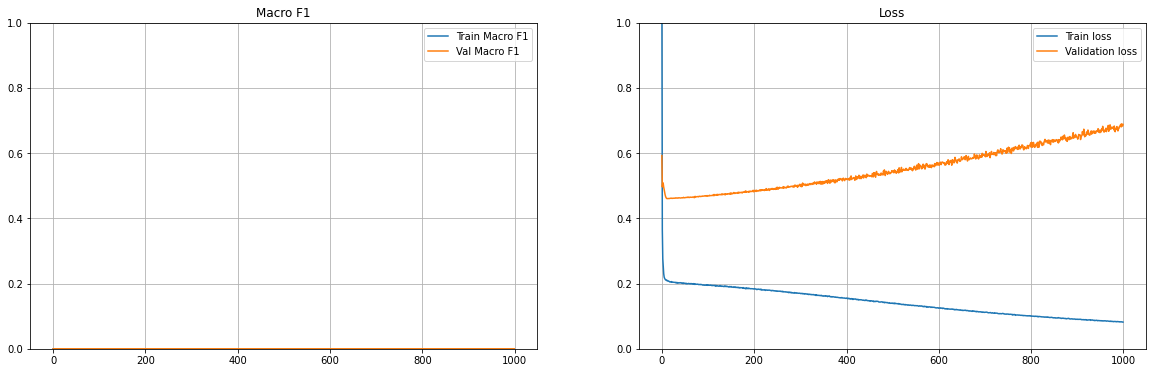

In [124]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Macro F1')
plt.plot(epoch_vl_acc, label='Val Macro F1')
plt.title("Macro F1")
plt.ylim([0,1])
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.ylim([0,1])
plt.legend()
plt.grid()

plt.savefig('../../../loss_f1score.png')
plt.show()

In [ ]:
model.load_state_dict(torch.load('../../../state_dict.pt'))
test_loss, test_score = evaluate(model, valid_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Score: {test_acc:.2f}%')